In [37]:
import pandas as pd
import numpy as np
import pylab as plt
import segyio
import os
import sys
from seislab.src import segyrw 
from seislab.src import plot_seismic
from LAS import Converter
from scipy import signal
from scipy.signal import medfilt
import laspy
from sklearn.linear_model import LinearRegression
from docx import Document
from numpy.linalg import solve
from matplotlib.colors import Normalize
from laspy.file import File
from Impulse  import impulse
from PlotData import PlotData as pltd
from WellData import WellData 
from SeismicData import SeismicData
from SliceViewer import SliceViewer
import neptune
%load_ext autoreload
%autoreload 2
%gui qt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


"diff" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [38]:
# функция сглаживания в разработке, не используется
def edge_preserving_smooth(sgn,win):
    win_len = win
    o = 0
    signal = sgn.copy()
    for i in np.arange(len(signal)):
        if i < win_len-1:
            o += 1
            pass
        elif i > len(signal)-win_len:
            pass
        else:
            I = []
            Ind1 = []
            Ind2 = []
            std = []
            for j in np.arange(win):
                ind1 = i+j-o
                ind2 = i+j+win_len-o
                I.append(i)
                Ind1.append(ind1)
                Ind2.append(ind2)
                std.append(np.std(signal[ind1:ind2]))
            df = pd.DataFrame({'i':I,'std':std,'ind1':Ind1,'ind2':Ind2})
            b = df.groupby('i')['std'].idxmin()
            b1 = int(df['ind1'][b.values].values)
            b2 = int(df['ind2'][b.values].values)
            signal[i] = signal[b1:b2].mean()
    return signal 
# поворот фазы сигнала
def ifft_with_phase(F, x, phase):
    sign = np.ones(len(x))
    sign[np.where(x<0)] = -1*sign[np.where(x<0)]
    sign[np.where(x==0)] = 0
    F_new = np.abs(F)*np.exp(-1j*(np.angle(F)+sign*phase))
    Finv = np.fft.ifft(F_new)
    return np.real(Finv)

# расчет огибающей сигнала
def envelope_calc(Finv):
    hilbert_signal = np.imag(signal.hilbert(Finv))
    envelope = np.sqrt(Finv*Finv+hilbert_signal*hilbert_signal)
    return envelope

## STACK [.sgy]


In [39]:
directory = 'sgyGleb/'

In [40]:
#прикрутить свою библиотеку

filename = directory+'307_Stk_w1.sgy'
seismicData=SeismicData.SeismicData(filename)

# вектор врмеен для сейсмики

In [41]:
seismicData.head[:100]


,TRACE_SEQUENCE_LINE,CDP_TRACE,TraceIdentificationCode,NSummedTraces,CoordinateUnits,TRACE_SAMPLE_COUNT,TRACE_SAMPLE_INTERVAL,CDP_X,CDP_Y,ILINE_NO,XLINE_NO,IDX
0,1716,26196,26196,1,1,2001,2000,499775,6637376,800,970,0
1,1717,26197,26197,1,1,2001,2000,499800,6637376,800,971,1
2,1718,26198,26198,1,1,2001,2000,499825,6637376,800,972,2
3,1719,26199,26199,1,1,2001,2000,499850,6637376,800,973,3
4,1720,26200,26200,1,1,2001,2000,499875,6637376,800,974,4
...,...,...,...,...,...,...,...,...,...,...,...,...
95,1731,32567,32567,1,1,2001,2000,500050,6637476,804,981,95
96,1732,32568,32568,1,1,2001,2000,500075,6637476,804,982,96
97,1733,32569,32569,1,1,2001,2000,500100,6637476,804,983,97
98,1734,32570,32570,1,1,2001,2000,500125,6637476,804,984,98


In [42]:
seismicData.get_spchere(500100,6637476,3)

,TRACE_SEQUENCE_LINE,CDP_TRACE,TraceIdentificationCode,NSummedTraces,CoordinateUnits,TRACE_SAMPLE_COUNT,TRACE_SAMPLE_INTERVAL,CDP_X,CDP_Y,ILINE_NO,XLINE_NO,IDX
31,1727,27796,27796,1,1,2001,2000,500025,6637401,801,980,31
32,1728,27797,27797,1,1,2001,2000,500050,6637401,801,981,32
33,1729,27798,27798,1,1,2001,2000,500075,6637401,801,982,33
34,1730,27799,27799,1,1,2001,2000,500100,6637401,801,983,34
35,1731,27800,27800,1,1,2001,2000,500125,6637401,801,984,35
36,1732,27801,27801,1,1,2001,2000,500150,6637401,801,985,36
37,1733,27802,27802,1,1,2001,2000,500175,6637401,801,986,37
52,1728,29386,29386,1,1,2001,2000,500025,6637426,802,980,52
53,1729,29387,29387,1,1,2001,2000,500050,6637426,802,981,53
54,1730,29388,29388,1,1,2001,2000,500075,6637426,802,982,54


In [43]:
%matplotlib notebook
%matplotlib inline

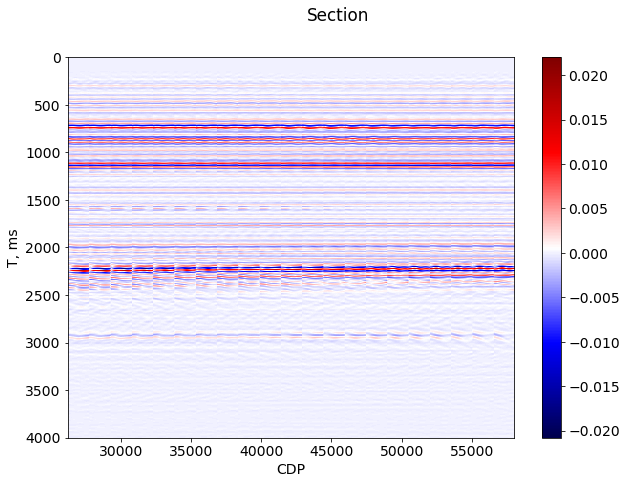

In [44]:
plt.rcParams.update({'font.size': 14})
fig,axs = plt.subplots(figsize = (10,7))
cs = axs.imshow(seismicData.data,aspect = 'auto',extent = [seismicData.head['CDP_TRACE'].min(),seismicData.head['CDP_TRACE'].max(),
                                                                 seismicData.dt*seismicData.data.shape[0],0],cmap='seismic')
cs2 = axs.imshow(seismicData.data,aspect = 'auto',extent = [seismicData.head['CDP_TRACE'].min(),seismicData.head['CDP_TRACE'].max(),
                                                                 seismicData.dt*seismicData.data.shape[0],0],cmap='seismic')
axs.set_xlabel('CDP')
axs.set_ylabel('T, ms')
fig.suptitle('Section')
fig.colorbar(cs, ax=axs)


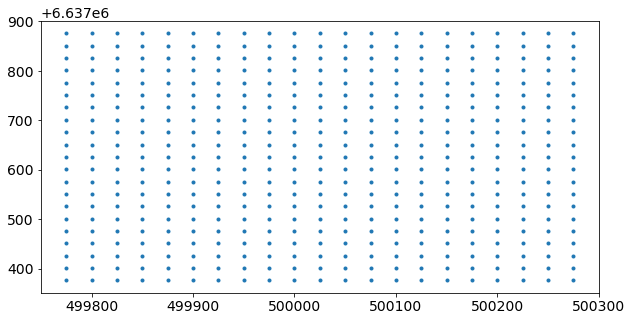

In [45]:
fig,axs = plt.subplots(figsize = (10,5))
axs.plot(seismicData.head['CDP_X'],seismicData.head['CDP_Y'],linewidth = 0,marker='.')

## WELL [.las]


In [46]:
xline_size = seismicData.head['XLINE_NO'].values.max() - seismicData.head['XLINE_NO'].values.min()
yline_size = seismicData.head['ILINE_NO'].values.max() - seismicData.head['ILINE_NO'].values.min()
data_cube = seismicData.data.reshape((seismicData.data.shape[0], xline_size + 1, yline_size + 1))
data_cube.shape

(2001, 21, 21)

In [47]:
import sys
from PyQt5.QtWidgets import QDialog, QApplication, QPushButton, QVBoxLayout, QLineEdit, QHBoxLayout, QLabel, QSlider, QComboBox
from PyQt5 import QtWidgets
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.backends.backend_qt5agg import NavigationToolbar2QT as NavigationToolbar
import matplotlib.pyplot as plt
from matplotlib.widgets import SpanSelector
import random
from matplotlib.figure import Figure
from PyQt5.QtCore import Qt
%gui qt

app = QtWidgets.QApplication.instance()
if app is None:
    app = QtWidgets.QApplication(sys.argv)
sliceViewwer = SliceViewer.SliceViewer(data_cube)
sliceViewwer.show()

In [48]:
directory="sgyGleb/"

In [49]:
path = directory +"Z-Zim-1_TIME.las"
wellData=WellData.WellData(path= path,
                params={"XCRD":"well_X","YCRD":"well_Y"},
                data={"depth":"Depth","tvdss":"TVDSS","time":"Time"})
    
well = wellData.convert_to_df_data()

{'well_X': 500001.0, 'well_Y': 6637623.6}


In [50]:
offsets=seismicData.get_offset(wellData) 

a=np.where(offsets<=np.min(offsets))
offsets_sort=np.argsort(offsets)
offsets[offsets_sort[0:10]]

array([  2.6       ,  22.62211308,  24.11970149,  26.11053427,
        27.4182421 ,  32.96604314,  34.44938316,  36.42471688,
        37.77247675,  47.61050304])

In [51]:
# считка данных со скважины (использовать библиотеку ИТСК)
path = directory +"Z-Zim-1jgw.las"
wellData2=WellData.WellData(path,data={"depth":"Depth_T","tvd":"TVD","tvdss":"TVDSS","dx":"DX",
                                        "dy":"DY","dts":"DTS","dt":"DT","rhob":"RHOB"},
                    del_invalid=True)

well_T = wellData2.convert_to_df_data()

In [52]:
well=wellData.merge(well_T,left_on="Depth",right_on='Depth_T')
wellData.set_reflectivity(params=["DT","RHOB"])

In [53]:
wellData.convert_to_df_data()

,Depth,TVDSS_x,Time,Depth_T,TVD,TVDSS_y,DX,DY,DTS,DT,RHOB,Reflectivity
0,1018.9464,973.4957,1.056899,1018.9464,1018.9257,973.4957,2.733678,3.587893,0.000882,0.000413,2189.6578,0.007999
1,1019.0988,973.6481,1.057036,1019.0988,1019.0781,973.6481,2.734593,3.588198,0.000897,0.000420,2194.1760,0.011334
2,1019.2512,973.8005,1.057174,1019.2512,1019.2305,973.8005,2.735507,3.588503,0.000933,0.000428,2184.1757,0.019443
3,1019.4036,973.9529,1.057312,1019.4036,1019.3829,973.9529,2.736422,3.588807,0.000990,0.000438,2151.1944,0.018529
4,1019.5560,974.1053,1.057450,1019.5560,1019.5353,974.1053,2.737336,3.589112,0.001006,0.000448,2119.7405,0.007654
...,...,...,...,...,...,...,...,...,...,...,...,...
13318,3048.6096,3002.2484,2.400263,3048.6096,3047.6784,3002.2484,24.185295,10.054864,0.000499,0.000247,2413.7525,-0.006307
13319,3048.7620,3002.4001,2.400332,3048.7620,3047.8301,3002.4001,24.183618,10.068580,0.000499,0.000249,2460.0000,0.001900
13320,3048.9144,3002.5519,2.400401,3048.9144,3047.9819,3002.5519,24.181942,10.082296,0.000499,0.000250,2460.0000,0.000704
13321,3049.0668,3002.7037,2.400470,3049.0668,3048.1337,3002.7037,24.180265,10.096012,0.000499,0.000250,2460.0000,0.000000


<ipython-input-54-061cac104d50>:10: RuntimeWarning: divide by zero encountered in true_divide
  plotdata_2_2= pltd.PlotData(2*np.diff(well['Depth'])/np.diff(well['Time']),well['Time'][1:],linewidth = 2,label='V_H(T0)')
C:\Users\Kognor\Desktop\учёба\python20k\307_Stk_w1\PlotData\PlotData.py:108: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(wspace=wspace,hspace=hspace)


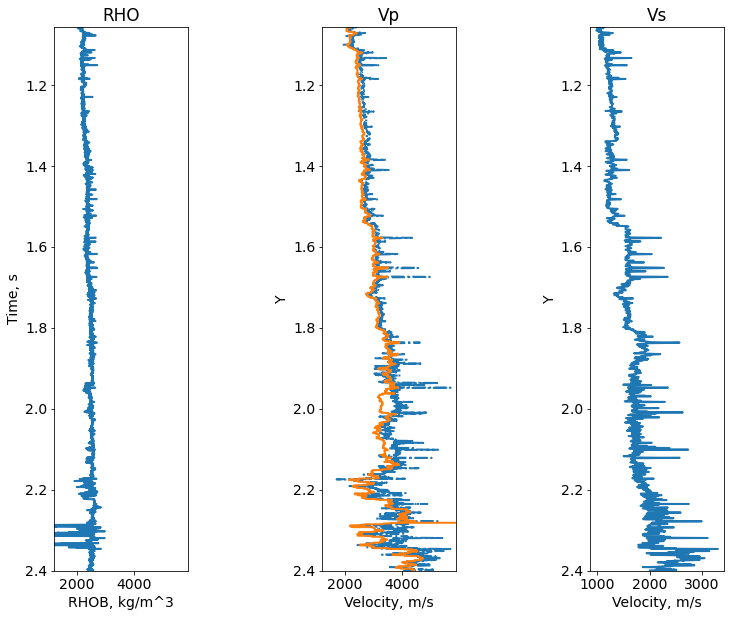

In [54]:
# визуализация скважинных данных от времени (плотность, скорость Вп по акустике/скорость Вп по закону H(T0), скорость Вс)
#че с осями
#Сперва готовим данные, что буди отображать на графике. 1 класс pltd.PlotData, грубо говоря, отвечает за одну линию на графике
plotdata_1= pltd.PlotData(well['RHOB'],#data x
                      well['Time'],#data y
                      linewidth = 2
                     )
#Допустим на графике по середине две линии plotdata_2_1 и pltd.PlotData_2_2
plotdata_2_1= pltd.PlotData(1/well['DT'],well['Time'],linewidth = 2,label='V_DT',linestyle="-.")
plotdata_2_2= pltd.PlotData(2*np.diff(well['Depth'])/np.diff(well['Time']),well['Time'][1:],linewidth = 2,label='V_H(T0)')

plotdata_3=pltd.PlotData(1/well['DTS'],well['Time'],linewidth = 2)

layers=[]
#pltd.SubFig(pltd.PlotData,...)- один график 
#У нас их три по этому pltd.SubFig() тоже 3
#Один pltd.SubFig опиывает один график
layers.append(pltd.SubFig([plotdata_1],#data
                      y_lim=[well['Time'].max(),well['Time'].min()],#limits
                      x_label="RHOB, kg/m^3",#x label
                      y_label="Time, s",#y label
                      title="RHO",#title
                      x_lim=[1200,5900]
                     ))
layers.append(pltd.SubFig([plotdata_2_1,plotdata_2_2],y_lim=[well['Time'].max(),well['Time'].min()],x_lim=[1200,5900],title="Vp",x_label="Velocity, m/s"))
layers.append(pltd.SubFig([plotdata_3],y_lim=[well['Time'].max(),well['Time'].min()],x_label='Velocity, m/s',title="Vs"))     
#Передаём количество графиков (1 строка 3 ряда), размер фигуры, слои
pltd.paint_subplots(1,3,figsize = (12,10),layers=layers,wspace=1)

<ipython-input-55-76d0c0be1a79>:3: RuntimeWarning: divide by zero encountered in true_divide
  plotdata_1=pltd.PlotData(1/well['DT'][1:]-2*np.diff(well['Depth'])/np.diff(well['Time']),well['Time'][1:],linewidth = 2,label='V_DT')
<ipython-input-55-76d0c0be1a79>:5: RuntimeWarning: divide by zero encountered in true_divide
  dV_otn=(1/well['DT'][1:]-2*np.diff(well['Depth'])/np.diff(well['Time']))*100/(1/well['DT'][1:])
C:\Users\Kognor\Desktop\учёба\python20k\307_Stk_w1\PlotData\PlotData.py:108: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(wspace=wspace,hspace=hspace)


inf

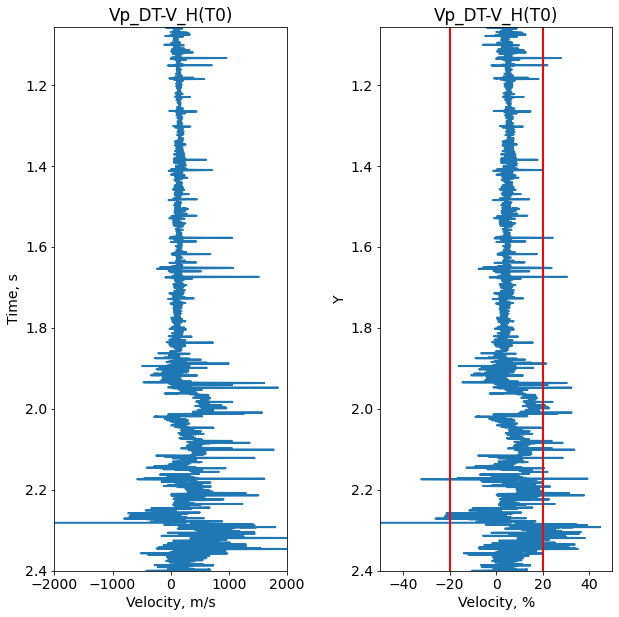

In [55]:
# визуализация разницы скоростей по акустике, по H(T0)

plotdata_1=pltd.PlotData(1/well['DT'][1:]-2*np.diff(well['Depth'])/np.diff(well['Time']),well['Time'][1:],linewidth = 2,label='V_DT')

dV_otn=(1/well['DT'][1:]-2*np.diff(well['Depth'])/np.diff(well['Time']))*100/(1/well['DT'][1:])
plotdata_2=pltd.PlotData(dV_otn,well['Time'][1:],linewidth = 2,label='dV_%')
plotdata_2_1=pltd.PlotData([-20, -20],[well['Time'].max(), well['Time'].min()],color='r')
plotdata_2_2=pltd.PlotData([20, 20],  [well['Time'].max(), well['Time'].min()],color='r')

layers=[]

layers.append(pltd.SubFig([plotdata_1],y_lim=[well['Time'].max(),well['Time'].min()],x_lim=[-2000,+2000],x_label='Velocity, m/s',y_label="Time, s",title="Vp_DT-V_H(T0)"))
layers.append(pltd.SubFig([plotdata_2,plotdata_2_1,plotdata_2_2],y_lim=[well['Time'].max(),well['Time'].min()],x_lim=[-50,50],x_label='Velocity, %',title="Vp_DT-V_H(T0)"))

pltd.paint_subplots(1,2,figsize = (10,10),layers=layers,wspace=0.4)    

np.max(abs(dV_otn))

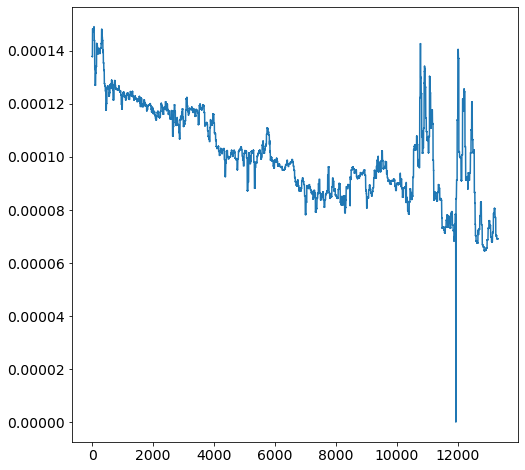

In [56]:
fig,axs = plt.subplots(figsize = (8,8))
axs.plot(np.diff(well['Time']))

In [57]:
# расчет коэффициентов отржаения по скважине (через Вп и плотность)
# вектор времен для данных со скважины (определять dt по среденему dt из закона H(T0))

T_well=np.arange(seismicData.Tdata[0],seismicData.Tdata[-1],0.0001)

Seismig_sig=seismicData.get_Seism_sig(T_well,a)
Refl_int=wellData.get_Refl_int(T_well)


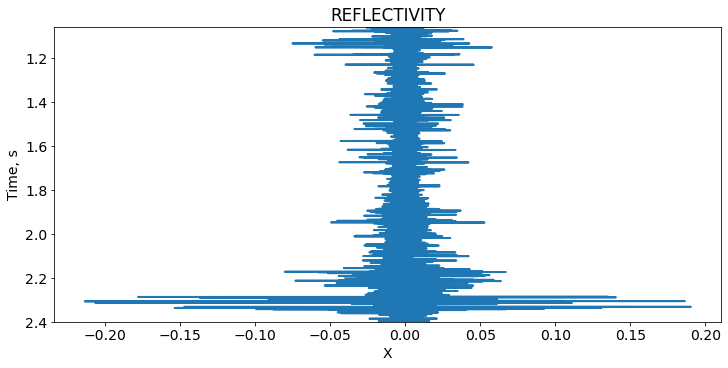

In [58]:
# визуализация коэффициентов отржажения
layers=[]
pltd.PlotData_1=pltd.PlotData(well['Reflectivity'],well['Time'],linewidth = 2)

layers.append(pltd.SubFig([pltd.PlotData_1],y_lim=[well['Time'].max(),well['Time'].min()], y_label="Time, s",title="REFLECTIVITY"))
pltd.paint_subplots(figsize = (10,5),layers=layers,wspace=0.4)


In [59]:
directory="sgyGleb/"

## Impulse [.xls]

In [60]:
imp =impulse.Impulse(directory+ "Multi_wavelets.csv",-0.2,0.2,0.0001)

Text(0.5, 1.0, 'Signal')

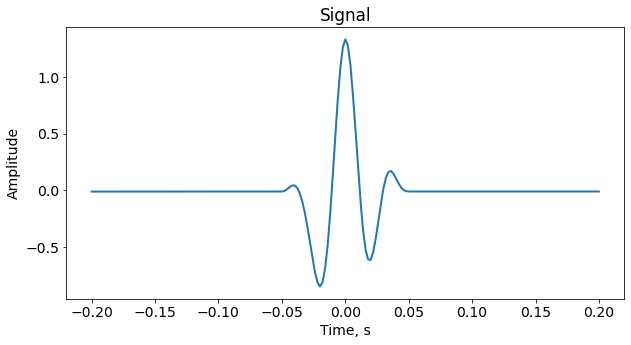

In [61]:
# визуализация сигнала

fig,axs = plt.subplots(figsize = (10,5))
axs.plot(imp.T_int2,imp.Sig,linewidth = 2)
axs.set_xlabel('Time, s')
axs.set_ylabel('Amplitude');
axs.set_title('Signal')

## Расчет метрик

In [62]:
# осреднение данных по сейсмике для нормальных спектров (нужно в каком то радиусе, тут для всей сейсмики)

Seism_sig_mean=np.zeros(np.shape(seismicData.data)[0])
for ii in range(0,np.shape(seismicData.data)[0]):
    Seism_sig_mean[ii]=np.mean(seismicData.data[ii,:])


Seism_sig_mean=np.interp(T_well,seismicData.Tdata,Seism_sig_mean)
    
# выделение целевого интервала (это входной параметр для всего инструмента)

Seism_sig_mean[0:10000]=0
Seism_sig_mean[24000:-1]=0

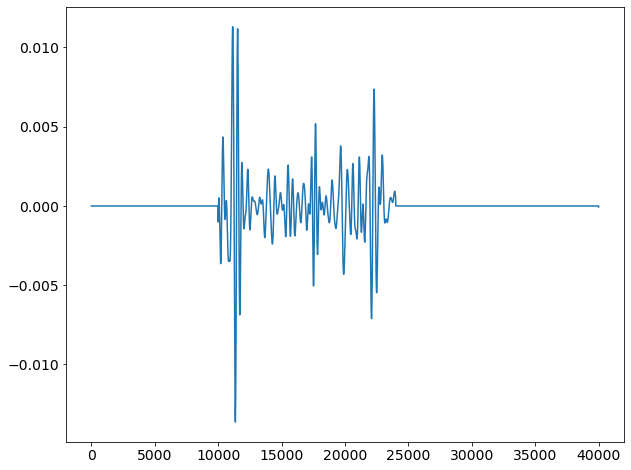

In [63]:
# визуализация осредненной трассы по сейсмике

fig, axs = plt.subplots(figsize = (10,8))
axs.plot(Seism_sig_mean)

In [64]:
from shapely.geometry import LineString
def intersection_point(x_2,f,g):
    
   
    first_line = LineString(np.column_stack((x_2, f)))
    second_line = LineString(np.column_stack((x_2, g)))
    intersection = first_line.intersection(second_line)
    x_1,y_1=LineString(intersection).xy
    x_1=np.array(x_1).reshape(len(np.array(x_1)),1)
    y_1=np.array(y_1).reshape(len(np.array(y_1)),1)
    return  x_1,y_1

In [65]:
def diff_1__3__2(x,ind2,ind3):
    return x[ind3]-x[ind2]

In [66]:

def Pha(x,z):
    
    ind = np.squeeze(np.where(x>0))
    x=x[ind]
    ind2 = np.squeeze(np.where(x<=60))#x.max x.min<=x[ind]<=x.max
    x_apr = x[ind2]#0..60
    reg1 = LinearRegression().fit(x_apr.reshape(-1, 1), z[ind[ind2]].reshape(-1, 1))
    z_apr = reg1.coef_*x_apr.reshape(-1, 1)+reg1.intercept_
    z_apr_extr=reg1.intercept_[0]
    Phase=np.round(z_apr_extr,2)#фаза
    A=(np.round(reg1.coef_[0][0],3))#Наклоны
    return Phase,A

In [67]:

def Freq(x,F):
 
    #Как-то можно лучше сдлеать по-любому
################################## 
    ind = np.squeeze(np.where(x>0))#>=0
    x=x[ind]
    F=F[ind]
    f=np.max(F)*np.ones(np.shape(x))*0.2
    g=np.abs(F)
    x_1,y_1= intersection_point(x,f,g)
    points=np.concatenate([x_1,y_1],axis=1)
    pt=[x[np.argmax(g)],np.amax(g)]
    x_max=[0,0]
    x_min=[0,0]
    for a,b in points:
        if(np.abs(a-pt[0])>x_max[0]):
            x_max=[a,b]
    for a_1,b_1 in points:
        if(np.abs(a_1-pt[0])>x_min[0] and a_1!= x_max[0]):
            x_min=[a_1,b_1]        

    print(x_max,x_min)
#######################################################  
    ind = np.squeeze(np.where(x>0))#>=0
    x=x[ind]
    F=F[ind]
    z=np.angle(F)
    ind2 = np.argmax(np.abs(F))#Доминантная частота сигнала(максимум графика)(index)
    
    Dom=x[ind2]#Доминантная частота сигнала
    Ampl_Dom=F[ind2]#Амплитуда доминантной частоты
    Width=(x_max[0]-x_min[0])#Ширина колокола
    
    
    return Dom,Ampl_Dom,x_min[0],x_max[0],Width

c:\users\kognor\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:318: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = array(a, dtype=dtype, order=order, copy=False, subok=subok)
c:\users\kognor\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:318: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = array(a, dtype=dtype, order=order, copy=False, subok=subok)


[38.40575954050064, 60.096293738018552] [4.8489929568684742, 60.096293738018552]
[13.113726418569046, 3.1522138368253048] [12.144694898263753, 3.1522138368253048]


c:\users\kognor\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Kognor\Desktop\учёба\python20k\307_Stk_w1\PlotData\PlotData.py:108: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(wspace=wspace,hspace=hspace)


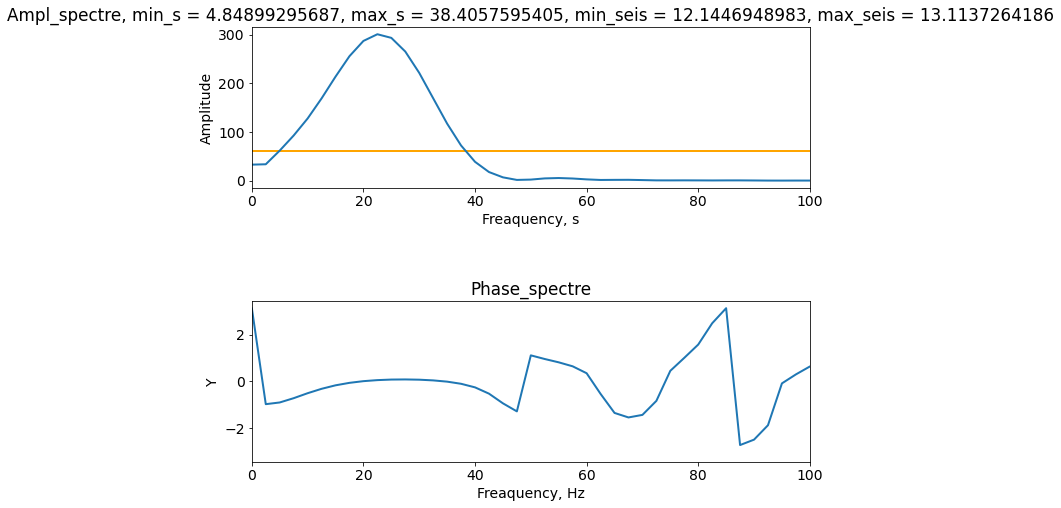

In [68]:
#Новая версия страшного блока

from scipy import spatial


dt=0.0001
F = np.fft.ifftshift(np.fft.fft(np.fft.ifftshift(imp.Sig)))
x = np.fft.ifftshift(np.fft.fftfreq(len(imp.Sig),dt))#Частоты

z=np.angle(F)
Dom,Ampl_Dom,x_min,x_max,Width=Freq(x,F)

Phase,A=Pha(x,z)

dt=0.0001
F2 = np.fft.ifftshift(np.fft.fft(np.fft.ifftshift(Seismig_sig)))
x2 = np.fft.ifftshift(np.fft.fftfreq(len(Seismig_sig),dt))
Dom2,Ampl_Dom2,x_min_2,x_max_2,Width=Freq(x2,F2)



ind = np.squeeze(np.where(x>0))#>=0

f=np.max(F)*np.ones(np.shape(x))*0.2
g=np.abs(F)
plotdata_1=pltd.PlotData(x,f,color='orange')
plotdata_2=pltd.PlotData(x,g,label = 'Signal_well')


plotdata_3=pltd.PlotData(x,z)
layers=[]
layers.append(pltd.SubFig([plotdata_1,plotdata_2],x_lim=[0,100],x_label='Freaquency, s',y_label="Amplitude",linestyle="--",title='Ampl_spectre, min_s = ' + str(x_min) + ', max_s = ' + str(x_max) + ', min_seis = ' + str(x_min_2) + ', max_seis = ' + str(x_max_2)))
layers.append(pltd.SubFig([plotdata_3],x_lim=[0,100],x_label='Freaquency, Hz',title="Phase_spectre"))
pltd.paint_subplots(2,1,figsize = (10,8),layers=layers,wspace=0.7)   

   

In [69]:
np.array([[1,0,1,0,0,1],[1,1,0,1,0,1], [1,1,0,0,1,0]]).T


array([[1, 1, 1],
       [0, 1, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 1, 0]])

In [70]:
# СВЕРТКА СИГНАЛА И КОЭФФИЦИЕНТОВ ОТРАЖЕНИЯ
print(imp.Sig)
print(Refl_int)
res=np.convolve(Refl_int, imp.Sig, mode='same')
# res2=np.convolve(Refl_int, signal, mode='same')

[-0.0116864 -0.0116864 -0.0116864 ..., -0.0108956 -0.0108956 -0.0108956]
[ 0.00799887  0.00799887  0.00799887 ...,  0.          0.
  0.        ]


C:\Users\Kognor\Desktop\учёба\python20k\307_Stk_w1\PlotData\PlotData.py:108: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(wspace=wspace,hspace=hspace)


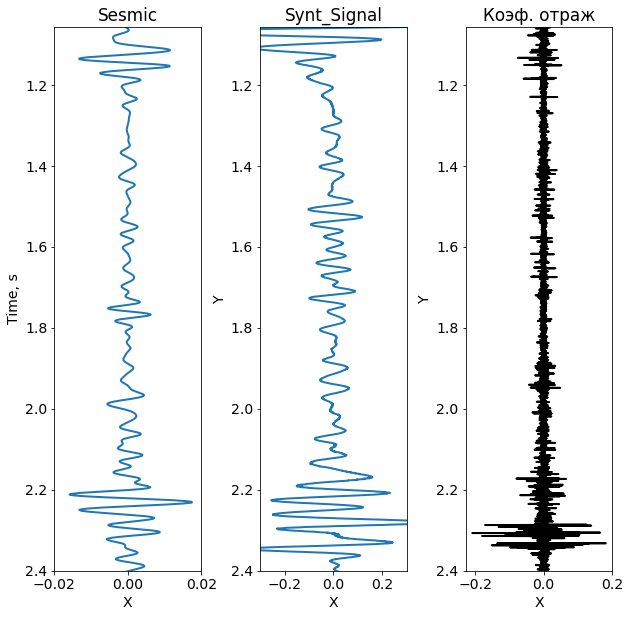

In [71]:
# визуализация ближней к скважине сейсмической трассы, свертки из прошлого блока, коэффициентов отражения


plotdata_1=pltd.PlotData(Seismig_sig,T_well,linewidth = 2)
plotdata_2=pltd.PlotData(res,T_well,linewidth = 2)
plotdata_3=pltd.PlotData(Refl_int,T_well,linewidth = 2,color = 'k')

layers=[]

layers.append(pltd.SubFig([plotdata_1],y_lim=[well['Time'].max(),well['Time'].min()],x_lim=[-0.02,0.02],y_label="Time, s",title="Sesmic"))
layers.append(pltd.SubFig([plotdata_2],y_lim=[well['Time'].max(),well['Time'].min()],x_lim=[-0.3,0.3],title="Synt_Signal"))
layers.append(pltd.SubFig([plotdata_3],y_lim=[well['Time'].max(),well['Time'].min()],title="Коэф. отраж"))

pltd.paint_subplots(1,3,figsize = (10,10),layers=layers,wspace=0.4)    


0.573830463569
646
590


Text(0.5, 1.0, 'FVK 1-2.4s, KK = -0.12, KK_max = 0.57, KKdt = 64.6 ms, Edt = 59.0 ms')

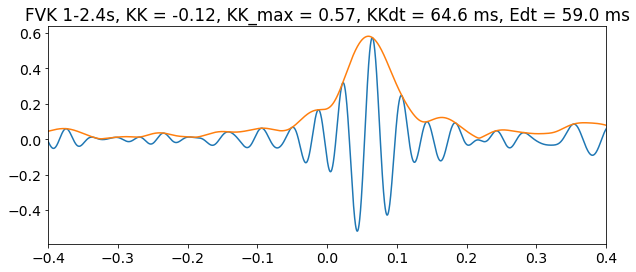

In [72]:
#Дальше уже ничего не трогал

#ФВК трассы сейсмики(не осредненной) и скважины, расчет метрик 

fig,axs = plt.subplots(figsize = (10,4))
Seism_sig2=Seismig_sig.copy()
res2=res.copy()
Seism_sig2[0:10000]=0 # выделение целевого интервала
Seism_sig2[24000:-1]=0
res2[0:10000]=0
res2[22500:-1]=0

resC=np.correlate(Seism_sig2, res2, mode='full')
resC=resC/(np.std(Seism_sig2)*np.std(res2)*len(res2))
resE=envelope_calc(resC)

KK0=(np.mean(Seism_sig2*res2)-np.mean(Seism_sig2)*np.mean(res2))/(np.std(res2)*np.std(Seism_sig2))
KK=resC[np.argmax(np.abs(resC))]
KKdt=np.argmax(resC)-len(res2)+1
Edt=np.argmax(resE)-len(res2)+1


print(KK)
print(KKdt)
print(Edt)

axs.plot(np.arange(-len(res2)+1,len(res2),1)*0.0001,resC)
axs.plot(np.arange(-len(res2)+1,len(res2),1)*0.0001,resE)
axs.set_xlim(-0.4,0.4)
axs.set_title('FVK 1-2.4s, KK = ' + str(np.round(KK0,2)) + ', KK_max = ' + str(np.round(KK,2)) +
              ', KKdt = ' + str(KKdt/10) + ' ms, Edt = ' + str(Edt/10) + ' ms')


In [73]:
# подготовка данных для норм визуализации (10 повторяющихся трасс со скважины, 10 ближайших к скважине трасс)

data_near_well_synt=np.zeros((len(res),10))
for ii in range(0,10):
    data_near_well_synt[:,ii]=res
    
    
data_near_well=np.zeros((len(res),10)) 
for ii in range(0,10):
    data_near_well[:,ii]=np.interp(T_well,seismicData.Tdata,np.squeeze(seismicData.data[:,offsets_sort[ii]]))
    

(2.4005392, 1.0568987)

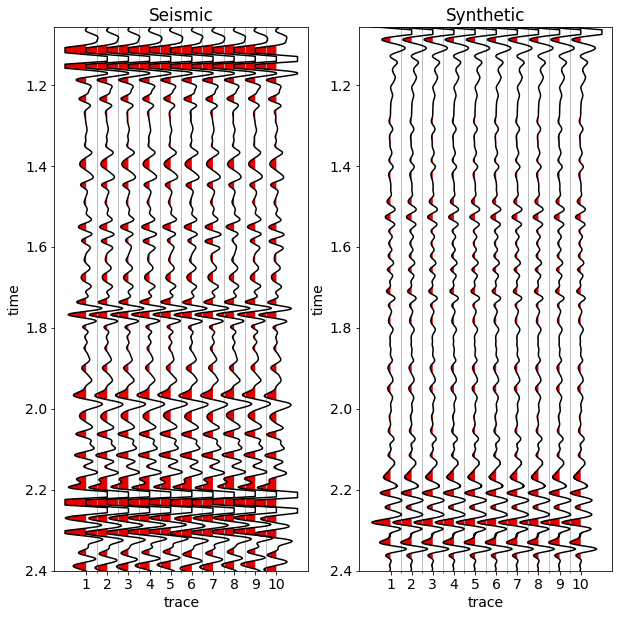

In [74]:
# проверка визуализации предыдущего блока

fig,axs = plt.subplots(1,2,figsize = (10,10))


plot_seismic.plot_traces(
    data_near_well.T, time_vertical=True, trace_color='k', 
    invert_y_axis=True,dt = 0.0001,
    fill_positive = True,
    fig_width=8,
    gain=5,
    clip=1,
    alpha = 1,
    ax=axs[0]
)

plot_seismic.plot_traces(
    data_near_well_synt.T, time_vertical=True, trace_color='k', 
    invert_y_axis=True,dt = 0.0001,
    fill_positive = True,
    fig_width=8,
    gain=4,
    clip=1,
    alpha = 1,
    ax=axs[1]
)

axs[0].set_title('Seismic')
axs[1].set_title('Synthetic')
axs[0].set_ylim(well['Time'].max(),well['Time'].min())
axs[1].set_ylim(well['Time'].max(),well['Time'].min())

In [75]:
# расчет КК (сейсмика-синтетика) в окне (подложка для визуализации)
win=1000
data_KK=np.zeros((len(res),10))
sig1=[]     
sig2=[]
corr12=[]                 
ttt=[]

for jj in range(0,10):
    for ii in range(win,len(res)-win):
        
        sig1=data_near_well[(ii-win):(ii+win),jj]
        sig2=data_near_well_synt[(ii-win):(ii+win),jj]
        ttt=np.arange(-len(sig1)+1,len(sig1),1)*0.0001
        
        data_KK[ii,jj]=(np.mean(sig1*sig2)-np.mean(sig1)*np.mean(sig2))/(np.std(sig2)*np.std(sig1))

<ipython-input-75-2a19027d306d>:16: RuntimeWarning: invalid value encountered in double_scalars
  data_KK[ii,jj]=(np.mean(sig1*sig2)-np.mean(sig1)*np.mean(sig2))/(np.std(sig2)*np.std(sig1))


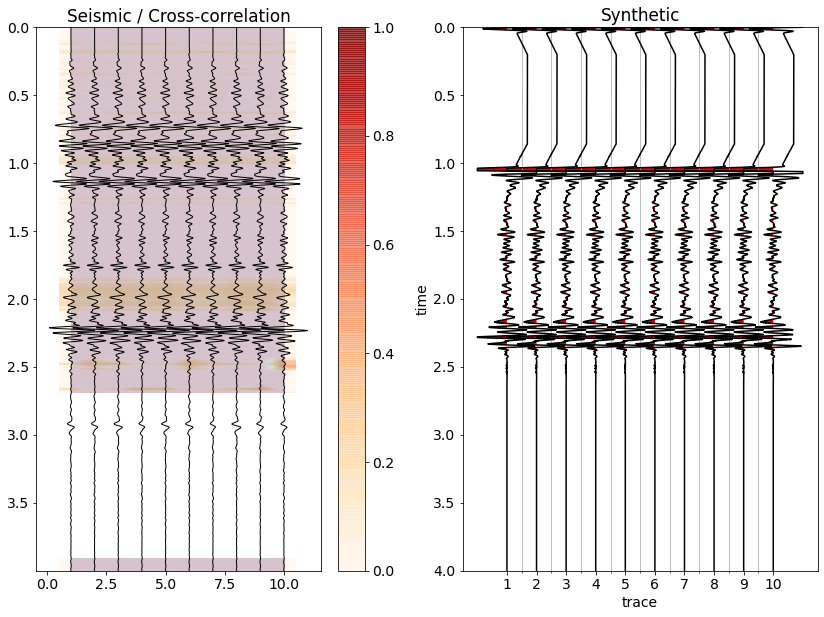

In [76]:
# визуализация предыдущего блока с трассами

fig,axs = plt.subplots(1,2,figsize = (14,10))


# alphas = Normalize(0, .2, clip=True)(np.abs(data_KK))
# alphas = np.clip(alphas, .2, 1)  # alpha value clipped at the bottom at .4



plot_seismic.plot_traces(
    data_near_well_synt.T, time_vertical=True, trace_color='k', 
    invert_y_axis=True,dt = 0.0001,
    fill_positive = True,
    fig_width=8,
    gain=5,
    clip=1,
    alpha = 1,
    ax=axs[1]
)
for ii in range(0,10):
    axs[0].plot(data_near_well[:,ii]/np.max(data_near_well[:,ii]).T+ii+1,T_well,'k',alpha=1,zorder=1,lw=1)
    
axs[0].imshow(data_KK,aspect = 'auto',vmin=0,vmax=1,extent=[1,10,T_well[-1],T_well[0]],alpha=0.7)
axs[0].set_title('Seismic / Cross-correlation')
axs[1].set_title('Synthetic')

cs=axs[0].imshow(data_KK,aspect = 'auto',vmin=0,vmax=1,extent=[0.5,10.5,T_well[-1],T_well[0]],alpha=0.7,cmap='OrRd')
# plt.set_cmap('OrRd')
# plt.set_cmap('brg')
fig.colorbar(cs, ax=axs[0])


# axs[0].plot(data_near_well[:,0]/np.max(data_near_well[:,0]).T+5,T_well,'k')
# np.linspace(0,10),T_well,
# np.linspace()

## мусор

In [ ]:
fig,axs = plt.subplots(figsize = (10,4))

axs.plot(data_KK[:,2])

In [ ]:

# data_near_well=res

In [ ]:
np.shape(data_near_well)

In [ ]:
offsets[offsets_sort[0:10]]

In [ ]:
fig,axs = plt.subplots(1,1,figsize = (10,10))

axs.plot(np.diff(well['Time']),linewidth = 2)

In [ ]:
filename1='w1_cdp.sgy'

In [ ]:
f = segyio.open(filename1, ignore_geometry = True)
data2 = segyio.tools.collect(f.trace[:])
data2 = data2.T

In [ ]:
%matplotlib notebook

In [ ]:
# plot_seismic.plot_traces(
#     data2[:,0:100].T, time_vertical=True, trace_color='k', 
#     invert_y_axis=True,dt = 2.0,
#     fill_positive = True,
#     fig_width=8,
#     gain=5,
#     clip=1,
#     alpha = 1,
# )

fig,axs = plt.subplots(figsize = (10,7))
axs.imshow(data2[:,0:100],aspect = 'auto')

In [ ]:
 data[:,0]